# Оценка риска ДПТ

Нужно создать систему, которая могла бы оценить риск ДТП по выбранному маршруту движения. Под риском понимается вероятность ДТП с любым повреждением транспортного средства. Как только водитель забронировал автомобиль, сел за руль и выбрал маршрут, система должна оценить уровень риска. Если уровень риска высок, водитель увидит предупреждение и рекомендации по маршруту.
Идея создания такой системы находится в стадии предварительного обсуждения и проработки. Чёткого алгоритма работы и подобных решений на рынке ещё не существует. Текущая задача — понять, возможно ли предсказывать ДТП, опираясь на исторические данные одного из регионов.

## Импорт библиотек

In [2]:
import numpy as np
import pandas as pd   
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
from phik import phik_matrix
from phik.report import plot_correlation_matrix

# Подготовка данных
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler

# Для пайплайна
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

# Модели
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
# from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix, f1_score, recall_score

# Игнорирование предупреждений
import warnings
warnings.filterwarnings('ignore')

In [3]:
RANDOM_STATE = 15

In [4]:
db_config = {
'user': 'praktikum_student', # имя пользователя,
'pwd': 'Sdf4$2;d-d30pp', # пароль,
'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
'port': 6432, # порт подключения,
'db': 'data-science-vehicle-db' # название базы данных,
} 

db_connection = 'postgresql://{}:{}@{}:{}/{}'.format(*db_config.values())
engine = create_engine(db_connection)

## Загрузка таблиц sql и их первичное исследование

In [5]:
#выведем все таблицы на экран
case_ids_query = '''
SELECT *
FROM case_ids
LIMIT 10
'''
pd.read_sql_query(case_ids_query, con=engine, index_col='case_id')

,db_year
case_id,
0081715,2021
0726202,2021
3858022,2021
3899441,2021
3899442,2021
3899445,2021
3899446,2021
3899449,2021
3899450,2021


In [6]:
query = '''
SELECT *
FROM vehicles
LIMIT 10
'''
pd.read_sql_query(query, con=engine, index_col='id')

,case_id,party_number,vehicle_type,vehicle_transmission,vehicle_age
id,,,,,
1175713,5305032,2,sedan,manual,3
1,3858022,1,sedan,auto,3
1175712,5305030,1,sedan,auto,3
1175717,5305033,3,sedan,auto,5
1175722,5305034,2,sedan,auto,5
1175737,5305046,2,sedan,auto,5
1175750,5305053,3,sedan,auto,9
1175715,5305033,1,sedan,manual,10
1175716,5305033,2,sedan,manual,4


In [7]:
query = '''
SELECT *
FROM collisions
WHERE EXTRACT(YEAR FROM collision_date::date) = 2012
LIMIT 10
'''
pd.read_sql_query(query, con=engine)

,case_id,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time
0,4750401,0103,alameda,0.0,None,1,cloudy,None,scratch,2,vehicle code violation,traffic signals and signs,broadside,other motor vehicle,wet,normal,daylight,functioning,2012-04-10,13:47:00
1,5087612,3300,riverside,450.0,north,0,clear,ramp,scratch,2,vehicle code violation,dui,rear end,other motor vehicle,dry,normal,dark with street lights not functioning,none,2012-01-15,20:23:00
2,5125192,4312,santa clara,30.0,south,0,cloudy,None,small damage,2,vehicle code violation,unsafe starting or backing,other,parked motor vehicle,dry,normal,daylight,functioning,2012-03-16,14:35:00
3,5457328,3711,san diego,5.0,west,0,clear,None,middle damage,2,None,None,broadside,bicycle,dry,normal,daylight,none,2012-01-20,13:30:00
4,5356548,3400,sacramento,10.0,south,0,clear,None,scratch,2,vehicle code violation,other hazardous violation,other,bicycle,dry,normal,daylight,functioning,2012-10-19,16:50:00
5,5356550,1942,los angeles,0.0,None,1,clear,None,scratch,2,vehicle code violation,traffic signals and signs,broadside,other motor vehicle,dry,normal,daylight,functioning,2012-09-28,15:00:00
6,5403029,4313,santa clara,0.0,None,1,fog,None,fatal,3,vehicle code violation,automobile right of way,broadside,other motor vehicle,wet,normal,daylight,None,2012-01-03,07:29:00
7,5403030,1942,los angeles,72.0,west,0,clear,None,fatal,3,other improper driving,other improper driving,rear end,None,dry,normal,dusk or dawn,functioning,2012-01-19,05:45:00
8,5403031,1500,kern,550.0,east,0,clear,highway,fatal,1,vehicle code violation,dui,hit object,fixed object,dry,normal,dusk or dawn,none,2012-01-13,06:05:00
9,5403033,3711,san diego,444.0,north,0,clear,None,fatal,1,vehicle code violation,improper turning,hit object,fixed object,dry,normal,dark with no street lights,none,2012-01-01,19:32:00


In [8]:
query = '''
SELECT *
FROM parties
WHERE party_type = 'car'
LIMIT 10
'''
pd.read_sql_query(query, con=engine, index_col='id')

,case_id,party_number,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use
id,,,,,,,,
29,3899462,2,car,0,21.0,had not been drinking,None,0
142,3982898,2,car,0,71.0,had not been drinking,None,0
171,3982914,2,car,0,43.0,had not been drinking,None,1
290,3984348,2,car,0,NaN,impairment unknown,G,0
397,3987634,1,car,1,54.0,had not been drinking,None,0
623,3990318,2,car,0,49.0,had not been drinking,None,0
812,3995210,1,car,1,32.0,had not been drinking,None,0
839,3995242,1,car,0,64.0,had not been drinking,None,0
893,3996586,1,car,1,46.0,had not been drinking,None,0


**Вывод**
<br>Все таблицы рабочие. Таблица case_ids не потребуется. Все таблицы связаны по ключу case_id. Условия: тип виновника — только машина (car) и данныe за 2012 год возможно соблюсти. Описаание таблиц не соответствует самим таблицам (например поле CONTROL_CONDITION_1 из описания не имеется в таблице collisions)

##  Проведите статистический анализ факторов ДТП

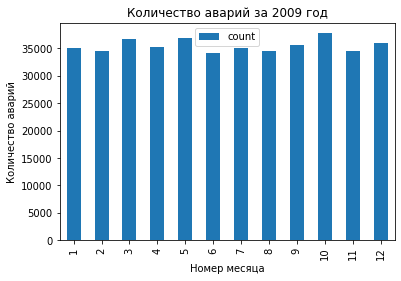

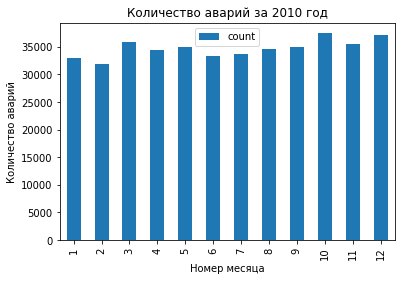

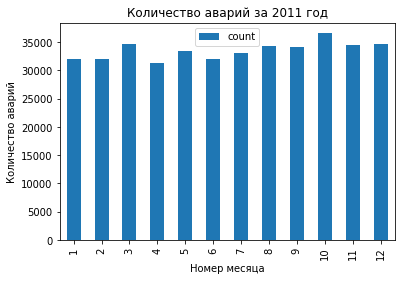

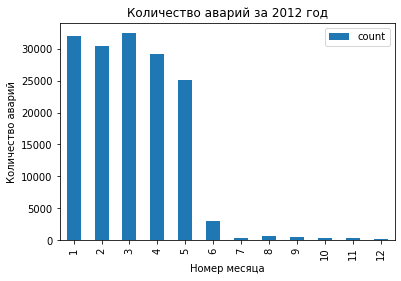

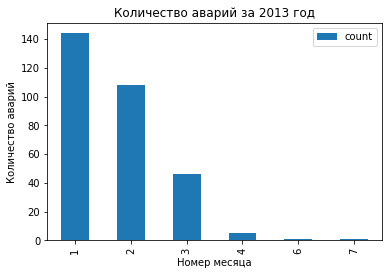

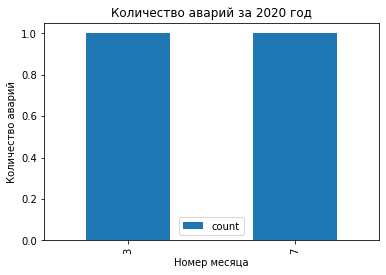

In [9]:
# выясним, в какие месяцы происходит наибольшее количество аварий

query = '''
SELECT CAST(EXTRACT(MONTH FROM collision_date::date) AS int) AS month_of_crash,
       CAST(EXTRACT(YEAR FROM collision_date::date) AS int) AS year_of_crash,
       COUNT(case_id)
FROM collisions
GROUP BY EXTRACT(YEAR FROM collision_date::date), EXTRACT(MONTH FROM collision_date::date)
'''

temp = pd.read_sql_query(query, con=engine, index_col='year_of_crash')

for year in temp.index.unique().to_list():
    t = temp[temp.index == year]
    t.plot(kind='bar', 
           x='month_of_crash',
           title=f'Количество аварий за {year} год',
           xlabel='Номер месяца',
           ylabel='Количество аварий')
plt.xticks(rotation=90);

Начиная с 2012 года в БД начали попадать не все данные, поскольку, судя по данным, с июня 2012 года аварий практически не происходило. Судя по полным данным реже всего происходили аварии в январе, феврале и июне, а чаще всего в марте и октябре и декабре.

Составим задачи для коллег-аналитиков:
1. Узнать, у каких типов автомобилей выше процент аварий кроме царапин(таблицы collisions и vehicles);
2. Как страховка зависит от возраста автомобиля (таблицы parties и vehicles);
2. Проведите анализ серьёзности повреждений транспортного средства, исходя из состояния дороги в момент ДТП (таблицы collisions и parties);
3. Найдите самые частые причины ДТП (таблица parties);
4. Узнать, в какую погоду аварии происходят чаще (таблица collisions);
5. Найдите самые частые последствия аварии (таблица collisions);
6. Кто чаще всего выступает вторым участником происшествия (таблица collisions).

<br> Решим для примера задачу №1:

In [10]:
query = '''
WITH t AS (SELECT v.vehicle_type,
                  COUNT(v.case_id) crash_count
           FROM collisions с
           JOIN vehicles v ON с.case_id = v.case_id
           WHERE collision_damage != 'scratch'
           GROUP BY v.vehicle_type)
           
SELECT t.vehicle_type,
       t.crash_count,
       COUNT(v.case_id) count_cars,
       t.crash_count::float / COUNT(v.case_id)::float * 100 precent_cases
FROM t
JOIN vehicles v ON t.vehicle_type = v.vehicle_type
GROUP BY t.vehicle_type, t.crash_count
'''

temp = pd.read_sql_query(query, con=engine, index_col='vehicle_type')
temp

,crash_count,count_cars,precent_cases
vehicle_type,,,
minivan,25687,43000,59.737209
hatchback,26240,45595,57.550170
sedan,344456,488665,70.489190
coupe,164209,442780,37.085912
other,583,1194,48.827471


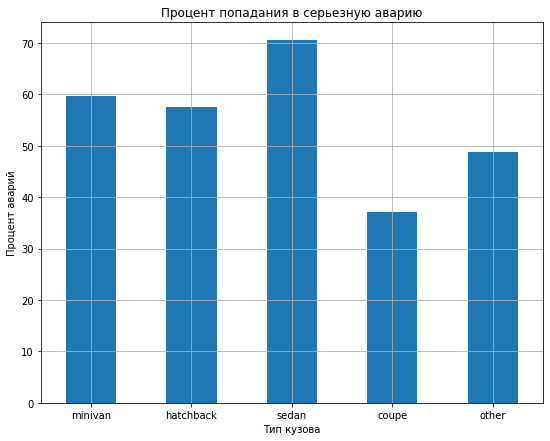

In [11]:
temp['precent_cases'].plot(kind='bar',
                           grid=True, 
                           figsize=(9, 7),
                           title='Процент попадания в серьезную аварию',
                           xlabel='Тип кузова',
                           ylabel='Процент аварий')
plt.xticks(rotation=0);

Из построенной диаграммы видно, что наиболее часто в серьезные аварии попадают автомобили типа сидан. Наименее часто купе.

Решим задачу №2:

In [12]:
query = '''
SELECT CAST(v.vehicle_age AS int),
       AVG(p.insurance_premium) insurance_premium
FROM vehicles v
JOIN parties p ON v.case_id = p.case_id
WHERE v.vehicle_age IS NOT NULL
GROUP BY v.vehicle_age
'''

temp = pd.read_sql_query(query, con=engine, index_col='vehicle_age')

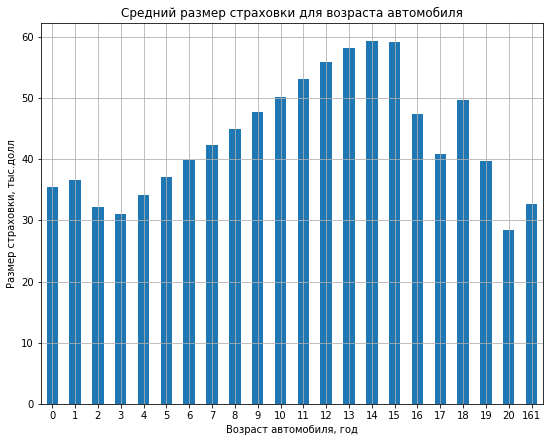

In [13]:
temp['insurance_premium'].plot(kind='bar',
                               grid=True, 
                               figsize=(9, 7),
                               title='Средний размер страховки для возраста автомобиля',
                               xlabel='Возраст автомобиля, год',
                               ylabel='Размер страховки, тыс.долл')
plt.xticks(rotation=0);

Как видно, как правило с повышением возраста автомобиля повышается и страховка, но это правило действует только для автомобилей от 2 до 15 лет С 16 до 20 лет страховка скорее понижается. Также имеется аномально высокий возраст авто - 161 год, что является выбросом.

**Вывод**
<br>По представленным данным видно, что в базу данных попало мало случаев аварий с июня по декабрь 2012 года. Либо данные были утеряны, либо в этот период не собирались вовсе. Для коллег-аналитиков был составлен ряд задач:
1. Узнать, у каких типов автомобилей выше процент аварий кроме царапин(таблицы collisions и vehicles);
2. Как страховка зависит от возраста автомобиля (таблицы parties и vehicles);
3. Проведите анализ серьёзности повреждений транспортного средства, исходя из состояния дороги в момент ДТП (таблицы collisions и parties);
4. Найдите самые частые причины ДТП (таблица parties);
5. Узнать, в какую погоду аварии происходят чаще (таблица collisions);
6. Найдите самые частые последствия аварии (таблица collisions);
7. Кто чаще всего выступает вторым участником происшествия (таблица collisions).

Например, решив первую задачу можно сделать вывод, что наиболее часто в серьезные аварии попадают автомобили типа сидан. Наименее часто купе. Решив вторую задачу, можно придти к выводу, что с повышением возраста автомобиля повышается и страховка, но это правило действует только для автомобилей от 2 до 15 лет С 16 до 20 лет страховка скорее понижается. Также имеется аномально высокий возраст авто - 161 год, что является мало вероятным событием.

## Выбор и обработка признаков для модели

Подготовим набор данных на основе первичного предположения заказчика:
1. Тип виновника — только машина (car);
2. ДТП привело к любым значимым повреждениям автомобиля любого из участников кроме типа SCRATCH (царапина);
3. Взять данные только за 2012 год.

In [14]:
query = '''
SELECT *, 
       EXTRACT (HOUR FROM collision_time) collision_hour,
       p.party_number party_number_p,
       v.party_number party_number_v
FROM collisions c
JOIN vehicles v ON c.case_id = v.case_id
JOIN parties p ON (v.case_id = p.case_id AND v.party_number = p.party_number)

WHERE party_type = 'car' AND 
      EXTRACT(YEAR FROM collision_date::date) = 2012 AND
      collision_damage != 'scratch'
'''

data = pd.read_sql_query(query, con=engine)
pd.set_option('display.max_columns', None)


In [15]:
data

,case_id,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time,id,case_id,party_number,vehicle_type,vehicle_transmission,vehicle_age,id,case_id,party_number,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use,collision_hour,party_number_p,party_number_v
0,5482705,3720,san diego,0.0,None,1.0,clear,None,small damage,2,vehicle code violation,automobile right of way,broadside,other motor vehicle,dry,normal,daylight,functioning,2012-01-26,07:40:00,1354645,5482705,1,sedan,manual,2.0,2458130,5482705,1,car,1,31.0,had not been drinking,None,0.0,7.0,1,1
1,5449062,0708,contra costa,21.0,east,0.0,clear,None,small damage,2,vehicle code violation,dui,rear end,other motor vehicle,dry,normal,dark with street lights,functioning,2012-01-15,02:00:00,1320506,5449062,2,sedan,manual,10.0,2395824,5449062,2,car,0,54.0,had not been drinking,None,0.0,2.0,2,2
2,5600850,5604,ventura,150.0,north,0.0,clear,highway,small damage,2,vehicle code violation,improper turning,sideswipe,other motor vehicle,dry,normal,daylight,none,2012-04-19,12:44:00,1465119,5600850,2,sedan,auto,NaN,2659554,5600850,2,car,0,NaN,impairment unknown,G,0.0,12.0,2,2
3,5600893,2908,nevada,190.0,east,0.0,clear,None,small damage,1,vehicle code violation,dui,hit object,other object,dry,normal,dark with no street lights,none,2012-04-21,00:50:00,1465137,5600893,1,sedan,auto,6.0,2659617,5600893,1,car,1,38.0,"had been drinking, under influence",None,0.0,0.0,1,1
4,5603123,1600,kings,2640.0,east,0.0,cloudy,highway,small damage,2,vehicle code violation,unsafe lane change,sideswipe,other motor vehicle,wet,normal,daylight,none,2012-04-13,14:34:00,1466829,5603123,1,sedan,auto,11.0,2662923,5603123,1,car,1,20.0,had not been drinking,None,0.0,14.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56243,5662345,3026,orange,900.0,north,0.0,clear,highway,middle damage,4,vehicle code violation,improper turning,sideswipe,other motor vehicle,dry,normal,daylight,none,2012-05-10,17:00:00,1511570,5662345,1,coupe,manual,8.0,2741204,5662345,1,car,1,50.0,had not been drinking,None,0.0,17.0,1,1
56244,5662494,1942,los angeles,0.0,None,1.0,clear,None,middle damage,2,vehicle code violation,traffic signals and signs,head-on,other motor vehicle,dry,normal,daylight,functioning,2012-05-25,15:25:00,1511737,5662494,2,coupe,manual,4.0,2741471,5662494,2,car,0,30.0,had not been drinking,None,1.0,15.0,2,2
56245,5667033,1915,los angeles,0.0,None,1.0,clear,None,middle damage,2,vehicle code violation,traffic signals and signs,broadside,other motor vehicle,dry,normal,daylight,functioning,2012-05-24,13:07:00,1516315,5667033,2,coupe,manual,5.0,2749910,5667033,2,car,0,34.0,had not been drinking,None,0.0,13.0,2,2
56246,5667756,4315,santa clara,0.0,None,1.0,clear,intersection,middle damage,2,vehicle code violation,wrong side of road,broadside,other motor vehicle,dry,normal,daylight,none,2012-04-21,12:58:00,1517038,5667756,1,coupe,manual,9.0,2751279,5667756,1,car,1,61.0,had not been drinking,None,0.0,12.0,1,1


Выгруженные по условиям Заказчика данные содержат 56248 случаев и состоят из 35 признаков. Признаков много, поэтому отберем из них самые полезные (Те, что сильнее всего коррелируют с таргетом). Уберем постфактумные признаки(например, collision_damage или party_count - они известны уже после аварии). Останутся следующие признаки:

In [16]:
columns = ['at_fault',  # целевой признак
           'county_location',  # география происшествия важна, а колонка county_city_location аналогична ей
           'distance',  # указывает на то, на главной дороге была авария или нет (будет переведено в булевый тип позже)
           'direction',
           'weather_1',  # погода может сильно влиять на вероятность аварии
           'location_type',  # тип дороги: шоссе, перекресток. Также включает в седя информацию из колонки intersection
           'road_surface',  # поверхность дороги сильно влияет на вероятность аварии
           'road_condition_1',  # состояние дороги сильно влияет на вероятность аварии
           'lighting',  # освещенность
           'control_device',   # функционирует ли устройство управления
           'collision_date',  # от даты (например дня недели) может многое зависеть
           'collision_hour',  # время (час) тоже влияет на вероятность аварии
           'insurance_premium',  # размер страховки может указывать на состояние автомобиля
           'party_sobriety',   # трезв ли водитель
           'party_drug_physical',  # состояние водителя  
           'vehicle_type',  # тип кузова важен (ранее выяснили это)
           'vehicle_age',   # возраст авто указывает на его состояние
           'vehicle_transmission'] 

data = data[columns]  # оставим выбранные признаки в датафрейме
data['collision_date'] = pd.to_datetime(data['collision_date'])

data.head(5)

,at_fault,county_location,distance,direction,weather_1,location_type,road_surface,road_condition_1,lighting,control_device,collision_date,collision_hour,insurance_premium,party_sobriety,party_drug_physical,vehicle_type,vehicle_age,vehicle_transmission
0,1,san diego,0.0,None,clear,None,dry,normal,daylight,functioning,2012-01-26,7.0,31.0,had not been drinking,None,sedan,2.0,manual
1,0,contra costa,21.0,east,clear,None,dry,normal,dark with street lights,functioning,2012-01-15,2.0,54.0,had not been drinking,None,sedan,10.0,manual
2,0,ventura,150.0,north,clear,highway,dry,normal,daylight,none,2012-04-19,12.0,NaN,impairment unknown,G,sedan,NaN,auto
3,1,nevada,190.0,east,clear,None,dry,normal,dark with no street lights,none,2012-04-21,0.0,38.0,"had been drinking, under influence",None,sedan,6.0,auto
4,1,kings,2640.0,east,cloudy,highway,wet,normal,daylight,none,2012-04-13,14.0,20.0,had not been drinking,None,sedan,11.0,auto


In [17]:
def about_df(list_df):
    '''выводит информацию о всех датасетах из списка list_df'''
    for c, i in enumerate(list_df):
        print("**** DATASET_"+str(c+1)+' ****')
        display(i.info())
        display(i.describe().round(2))
        print(f'Количество дубликатов: {i.duplicated().sum()}')
        print('Количество пропущенных значений:', i.isnull().sum(), sep='\n')
        print()

In [18]:
about_df([data])

**** DATASET_1 ****
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56248 entries, 0 to 56247
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   at_fault              56248 non-null  int64         
 1   county_location       56248 non-null  object        
 2   distance              56248 non-null  float64       
 3   direction             43230 non-null  object        
 4   weather_1             56080 non-null  object        
 5   location_type         25932 non-null  object        
 6   road_surface          55900 non-null  object        
 7   road_condition_1      55999 non-null  object        
 8   lighting              56094 non-null  object        
 9   control_device        56033 non-null  object        
 10  collision_date        56248 non-null  datetime64[ns]
 11  collision_hour        56160 non-null  float64       
 12  insurance_premium     55701 non-null  float64       
 

None

,at_fault,distance,collision_hour,insurance_premium,vehicle_age
count,56248.0,56248.00,56160.00,55701.00,54554.00
mean,0.5,859.44,13.32,37.61,4.86
std,0.5,7240.30,5.53,16.33,3.23
min,0.0,0.00,0.00,0.00,0.00
25%,0.0,7.00,10.00,24.00,3.00
50%,1.0,135.00,14.00,34.00,4.00
75%,1.0,545.00,17.00,49.00,7.00
max,1.0,1584000.00,23.00,105.00,161.00


Количество дубликатов: 33
Количество пропущенных значений:
at_fault                    0
county_location             0
distance                    0
direction               13018
weather_1                 168
location_type           30316
road_surface              348
road_condition_1          249
lighting                  154
control_device            215
collision_date              0
collision_hour             88
insurance_premium         547
party_sobriety            872
party_drug_physical     53391
vehicle_type                0
vehicle_age              1694
vehicle_transmission      859
dtype: int64



In [19]:
# проверим, есть ли неявные дубликаты в колонках типа object
cat_cols = data.select_dtypes(include=['object']).columns.to_list()

for i in cat_cols:
    print(i)
    print(data[i].unique())
    print()

county_location
['san diego' 'contra costa' 'ventura' 'nevada' 'kings' 'solano' 'orange'
 'san joaquin' 'los angeles' 'riverside' 'sacramento' 'san bernardino'
 'alameda' 'shasta' 'sonoma' 'kern' 'el dorado' 'modoc' 'fresno' 'yolo'
 'tuolumne' 'santa clara' 'placer' 'san mateo' 'stanislaus'
 'san luis obispo' 'tehama' 'mendocino' 'san francisco' 'tulare'
 'san benito' 'santa barbara' 'marin' 'monterey' 'mariposa' 'santa cruz'
 'lassen' 'madera' 'inyo' 'yuba' 'merced' 'napa' 'calaveras' 'imperial'
 'sutter' 'plumas' 'humboldt' 'mono' 'butte' 'colusa' 'alpine' 'del norte'
 'siskiyou' 'lake' 'amador' 'trinity' 'glenn' 'sierra']

direction
[None 'east' 'north' 'south' 'west']

weather_1
['clear' 'cloudy' 'fog' 'raining' None 'other' 'snowing' 'wind']

location_type
[None 'highway' 'ramp' 'intersection']

road_surface
['dry' 'wet' 'snowy' None 'slippery']

road_condition_1
['normal' None 'other' 'loose material' 'construction' 'obstruction'
 'holes' 'flooded' 'reduced width']

lighting
['da

In [20]:
data['control_device'] = data['control_device'].replace(['none', 'obscured'], 'unknown')

Представленные данные содержат ненормально высокие значения в колонках distance, vehicle_age. Имеются дубликаты:. Удалим дубли:

In [21]:
data = data.drop_duplicates().reset_index(drop=True)

Пропуски в категориальных столбцах заполним значением 'unknown'. Численные пропуски заполним медианными значениями:

In [22]:
data[cat_cols] = data[cat_cols].fillna('unknown')

for i in ['distance', 'collision_hour', 'insurance_premium', 'vehicle_age']:
    median_val = data[i].median()
    data[i].fillna(median_val, inplace=True)

In [23]:
about_df([data])

**** DATASET_1 ****
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56215 entries, 0 to 56214
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   at_fault              56215 non-null  int64         
 1   county_location       56215 non-null  object        
 2   distance              56215 non-null  float64       
 3   direction             56215 non-null  object        
 4   weather_1             56215 non-null  object        
 5   location_type         56215 non-null  object        
 6   road_surface          56215 non-null  object        
 7   road_condition_1      56215 non-null  object        
 8   lighting              56215 non-null  object        
 9   control_device        56215 non-null  object        
 10  collision_date        56215 non-null  datetime64[ns]
 11  collision_hour        56215 non-null  float64       
 12  insurance_premium     56215 non-null  float64       
 

None

,at_fault,distance,collision_hour,insurance_premium,vehicle_age
count,56215.0,56215.00,56215.00,56215.00,56215.00
mean,0.5,859.79,13.32,37.57,4.83
std,0.5,7242.40,5.52,16.25,3.19
min,0.0,0.00,0.00,0.00,0.00
25%,0.0,7.00,10.00,24.00,3.00
50%,1.0,135.00,14.00,34.00,4.00
75%,1.0,545.00,17.00,48.00,7.00
max,1.0,1584000.00,23.00,105.00,161.00


Количество дубликатов: 0
Количество пропущенных значений:
at_fault                0
county_location         0
distance                0
direction               0
weather_1               0
location_type           0
road_surface            0
road_condition_1        0
lighting                0
control_device          0
collision_date          0
collision_hour          0
insurance_premium       0
party_sobriety          0
party_drug_physical     0
vehicle_type            0
vehicle_age             0
vehicle_transmission    0
dtype: int64



Из даты выделим месяц и день недели аварии:

In [25]:
data['case_month'] = data['collision_date'].dt.month_name()
data['case_weekday'] = data['collision_date'].dt.dayofweek.astype('str')

data = data.drop('collision_date', axis=1)  # колонка с датой уже не нужна

data[['distance', 'vehicle_age', 'collision_hour']] = \
    data[['distance', 'vehicle_age', 'collision_hour']].astype('int')   # изменим тип на int

data['case_weekday'].unique()  # проверим дни недели, должно быть 7 уникальных значений

array(['3', '6', '5', '4', '0', '2', '1'], dtype=object)

In [26]:
data.head(3)

,at_fault,county_location,distance,direction,weather_1,location_type,road_surface,road_condition_1,lighting,control_device,collision_hour,insurance_premium,party_sobriety,party_drug_physical,vehicle_type,vehicle_age,vehicle_transmission,case_month,case_weekday
0,1,san diego,0,unknown,clear,unknown,dry,normal,daylight,functioning,7,31.0,had not been drinking,unknown,sedan,2,manual,January,3
1,0,contra costa,21,east,clear,unknown,dry,normal,dark with street lights,functioning,2,54.0,had not been drinking,unknown,sedan,10,manual,January,6
2,0,ventura,150,north,clear,highway,dry,normal,daylight,unknown,12,34.0,impairment unknown,G,sedan,4,auto,April,3


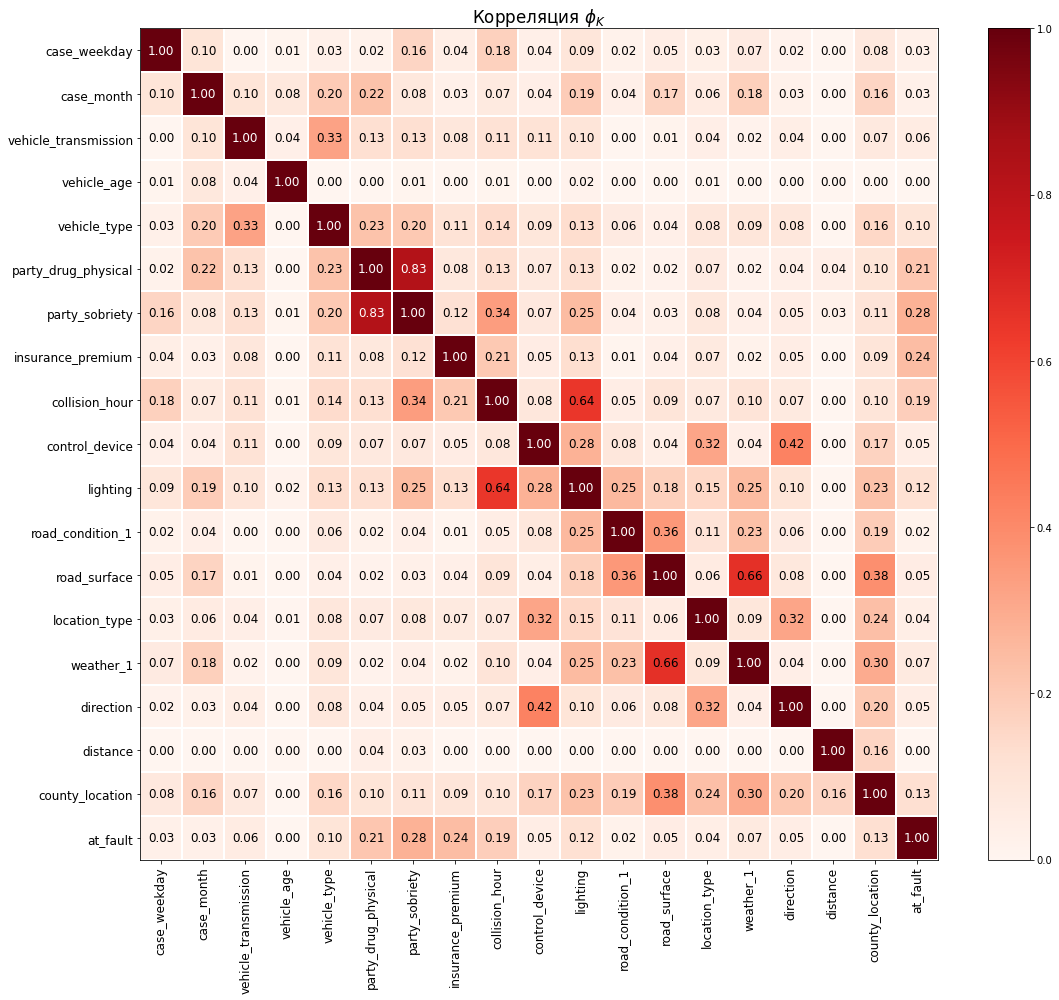

In [27]:
# выполним расчет корреляции 
interval_cols = list(data._get_numeric_data().columns)
phik_overview = data.phik_matrix(interval_cols=interval_cols)

# heatmap
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Reds',
    title=r'Корреляция $\phi_K$',
    fontsize_factor=1.2,
    figsize=(16, 14)
) 

Для моделирования оставим только те признаки, которые лучше коррелируют с таргетом:

In [28]:
columns = ['vehicle_type', 'party_drug_physical', 'party_sobriety', 
           'insurance_premium', 'collision_hour', 'lighting', 'county_location', 'at_fault']
 
data = data[columns]

In [29]:
about_df([data])

**** DATASET_1 ****
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56215 entries, 0 to 56214
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   vehicle_type         56215 non-null  object 
 1   party_drug_physical  56215 non-null  object 
 2   party_sobriety       56215 non-null  object 
 3   insurance_premium    56215 non-null  float64
 4   collision_hour       56215 non-null  int64  
 5   lighting             56215 non-null  object 
 6   county_location      56215 non-null  object 
 7   at_fault             56215 non-null  int64  
dtypes: float64(1), int64(2), object(5)
memory usage: 3.4+ MB


None

,insurance_premium,collision_hour,at_fault
count,56215.00,56215.00,56215.0
mean,37.57,13.32,0.5
std,16.25,5.52,0.5
min,0.00,0.00,0.0
25%,24.00,10.00,0.0
50%,34.00,14.00,1.0
75%,48.00,17.00,1.0
max,105.00,23.00,1.0


Количество дубликатов: 16806
Количество пропущенных значений:
vehicle_type           0
party_drug_physical    0
party_sobriety         0
insurance_premium      0
collision_hour         0
lighting               0
county_location        0
at_fault               0
dtype: int64



**Вывод**
<br>Набор данных был подготовлен на основе первичного предположения заказчика:
1. Тип виновника — только машина (car);
2. ДТП привело к любым значимым повреждениям автомобиля любого из участников кроме типа SCRATCH (царапина);
3. Необходимы данные только за 2012 год.

Выгруженные по условиям Заказчика данные содержат 56247 случаев и состоят из множества признаков. Из признаков отберем для моделированиия самые полезные (те, что сильнее всего коррелируют с таргетом) Уберем постфактумные признаки (например, количество участников в аварии - они известны уже после аварии). В результате осталось только 7 признаков.
<br>Пропуски в категориальных столбцах были заполнены значением 'unknown'. Численные пропуски заполнены медианными значениями.

## EDA

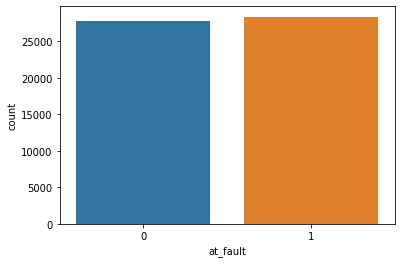

In [30]:
# покажем, сбалансированные ли данные по целдевому признаку
sns.countplot(data = data, x='at_fault');

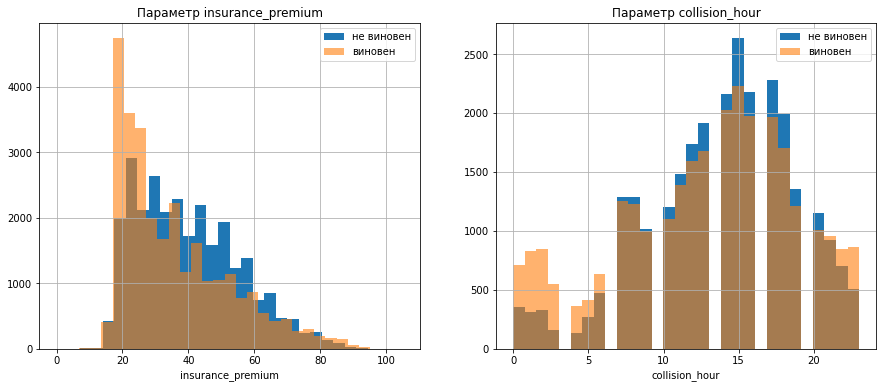

In [31]:
# посторим распреления численных признаков в зависимости от вины участника
temp_0 = data.query('at_fault == 0') 
temp_1 = data.query('at_fault == 1') 

num_cols = ['insurance_premium', 'collision_hour']

fig, axes = plt.subplots(1, 2, figsize=(15, 6))
axe = axes.ravel()

for i, c in enumerate(num_cols):
    temp_0[c].hist(bins=30, label='не виновен', ax=axe[i])
    temp_1[c].hist(bins=30, label='виновен', alpha=0.6, ax=axe[i])
    axe[i].set_title(f'Параметр {c}')
    axe[i].set_xlabel(c)
    axe[i].legend()
plt.show()

Видно, что водители на автомобилях с размером страховки до 30 тыс. и более 80 тыс. чаще виновны, чем водители со страховкой между этими значениями. В авариях с 21.00 до 6.00 чаще виноваты водители.

<br>Посмотрим на распределение аварий по категориальным признакам:

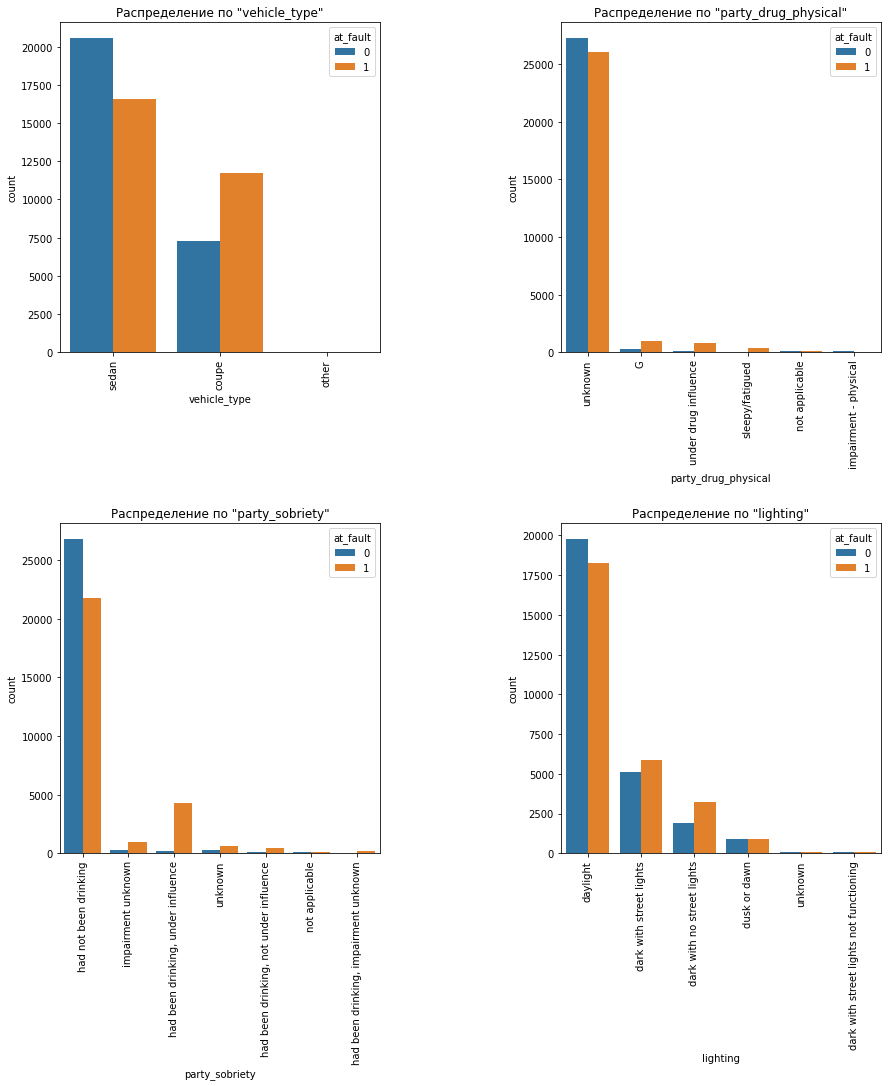

In [32]:
cat_cols = ['vehicle_type', 'party_drug_physical',
            'party_sobriety', 'lighting']

fig, axes = plt.subplots(2, 2, figsize=(16, 16))
axe = axes.ravel()

fig.tight_layout(pad=15)
for i, c in enumerate(cat_cols):
    sns.countplot(data = data, x=c, hue='at_fault', ax=axe[i])
    axe[i].set_xlabel(c)
    axe[i].set_title(f'Распределение по "{c}"')
    axe[i].tick_params(axis='x', rotation=90)
    
plt.show()

Водители купе чаще оказываются виновниакми ДТП, чем сиданов. Информации по состоянию водителя (party_drug_physical, party_sobriety) по большей части отсутствует. Трезвые водители реже оказываются виновниками, но при этом трезвые водители участвовали в большинстве аварий. при дневном свете водители также часто оказываются невиновными (как выяснили ранее, водители вцелом днем реже виновники).

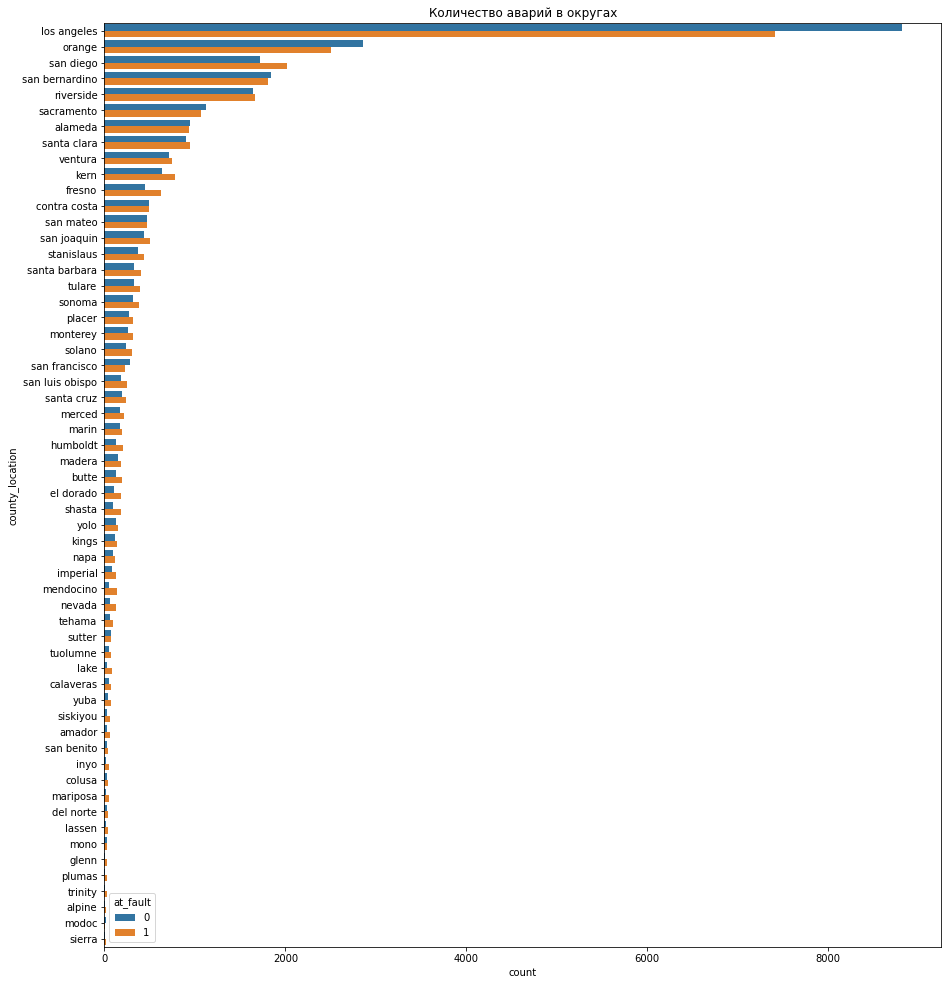

In [33]:
# посмотрим на виновность водителей по округам
plt.subplots(figsize=(15, 17))
sns.countplot(data = data, 
              y='county_location', 
              hue='at_fault', 
              order=data['county_location'].value_counts().index)
plt.title('Количество аварий в округах');

Можно заметить, что в крупных округах водители реже виноваты. В малых же напротив водители чаще виноваты в ДТП. Исходя из этого факта можно выделить в отдельную группу others все мелкие округа:

In [34]:
# оставим 13 самых частых локаций, остальные сведем в группу others
big_locations = data['county_location'].value_counts()\
                                       .sort_values(ascending=False)\
                                       .head(13)\
                                       .index\
                                       .to_list()

data['county_location'] = np.where(~data['county_location'].isin(big_locations), 'others', data['county_location'])
data['county_location'].value_counts()

los angeles       16226
others            12155
orange             5358
san diego          3737
san bernardino     3646
riverside          3312
sacramento         2184
alameda            1875
santa clara        1843
ventura            1464
kern               1415
fresno             1073
contra costa        989
san mateo           938
Name: county_location, dtype: int64

**Вывод**
<br>Данные по целевому приизнаку сбалансированы (виновных в аварии автомобилей примерно столько же, сколько и невиновных). Видно, что водители на автомобилях с размером страховки до 30 тыс. и более 80 тыс. чаще виновны, чем водители со страховкой между этими значениями. В авариях с 21.00 до 6.00 чаще виноваты водители. Водители купе в 2012 году чаще оказывались виновниакми ДТП, чем сиданов. Информации по состоянию водителя (party_drug_physical, party_sobriety) по большей части отсутствует. Трезвые водители реже оказываются виновниками, но при этом трезвые водители участвовали в большинстве аварий. при дневном свете водители также часто оказываются невиновными (как выяснили ранее, водители вцелом днем реже виновники). Можно заметить, что в крупных округах водители реже виноваты. В малых же напротив водители чаще виноваты в ДТП.

## Подготовка данных для моделирования

In [35]:
# деление на тренировочную, тестовую и валидационную выборки
X_train, X_test, y_train, y_test = train_test_split(data.drop('at_fault', axis=1), 
                                                    data['at_fault'], 
                                                    test_size=0.2, 
                                                    random_state=RANDOM_STATE)

print('train size:', X_train.shape, ' test size:', X_test.shape)

train size: (44972, 7)  test size: (11243, 7)


In [36]:
data.head()

,vehicle_type,party_drug_physical,party_sobriety,insurance_premium,collision_hour,lighting,county_location,at_fault
0,sedan,unknown,had not been drinking,31.0,7,daylight,san diego,1
1,sedan,unknown,had not been drinking,54.0,2,dark with street lights,contra costa,0
2,sedan,G,impairment unknown,34.0,12,daylight,ventura,0
3,sedan,unknown,"had been drinking, under influence",38.0,0,dark with no street lights,others,1
4,sedan,unknown,had not been drinking,20.0,14,daylight,others,1


In [37]:
# выделим категориальные и численные столбцы
num_cols = ['insurance_premium', 'collision_hour']

cat_cols = ['vehicle_type', 'party_drug_physical', 'party_sobriety', 
            'lighting', 'county_location']

**Вывод**
<br>Данные разбиты на тестовую и тренировочную выборки.

## Модель для оценки водительского риска

Поскольку наблюдений много (более 50 тыс.) то нейросеть строить не будем (даже с меньшим количеством наблюдейний обучение затянется).
Сравнивать будем 3 модели в пайплайне: KNeighborsClassifier, LGBMClassifier и CatBoostClassifier. За метрику качества возьмем roc_auc, которая показывает, насколько хорошо классификатор различает положительные и отрицательные классы.

In [38]:
ohe_pipe = Pipeline(   # пайплайн для кодирования
    [('simpeImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('ohe', OneHotEncoder(drop='first', sparse=False))])

data_preprocessor = ColumnTransformer(
    [('cat', ohe_pipe, cat_cols),
    ('num', RobustScaler(), num_cols)], remainder='passthrough')

In [39]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LogisticRegression(random_state=RANDOM_STATE))])

param_grid = [

    # модель KNeighborsClassifier
     {'models': [KNeighborsClassifier()],
      'preprocessor__cat': [ohe_pipe, 'passthrough'],
      'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']},   
        
    # модель LGBMClassifier
     {'models': [LGBMClassifier(silent=True)],
      'models__n_estimators': [1000, 1500],
      'models__max_depth': [10, 15],
      'preprocessor__cat': [ohe_pipe, 'passthrough'],
      'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']},
    
    # модель CatBoostClassifier
     {'models': [CatBoostClassifier(silent=True)],
      'models__iterations': [100, 200],
      'preprocessor__cat': [ohe_pipe, 'passthrough'],
      'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']},
]

In [40]:
best_model = RandomizedSearchCV(pipe_final,
                                param_grid,
                                cv=5,
                                scoring='roc_auc',
                                random_state=RANDOM_STATE,
                                n_jobs=-1)

In [41]:
best_model.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('cat',
                                                                               Pipeline(steps=[('simpeImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              sparse=False))]),
                                                                               ['vehicle_type',
                                 

In [42]:
print('Метрика roc_auc лучшей модели:', best_model.best_score_)

Метрика roc_auc лучшей модели: 0.7051701358002391


In [43]:
best_model.best_params_

{'preprocessor__num': MinMaxScaler(),
 'preprocessor__cat': Pipeline(steps=[('simpeImputer_ohe', SimpleImputer(strategy='most_frequent')),
                 ('ohe', OneHotEncoder(drop='first', sparse=False))]),
 'models__iterations': 200,
 'models': <catboost.core.CatBoostClassifier at 0x7f8c8c8035e0>}

In [44]:
pred = best_model.predict_proba(X_test)[:, 1]
roc_auc_score(y_test, pred)

0.7110972634486914

Лучшей моделью оказалась CatBoost с метрикой roc_auc = 0.71 на тренировочных и тестовых данных, что является хорошим результатом.
Построим матрицу ошибок модели:

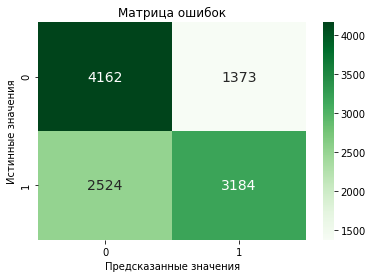

In [45]:
y_pred = best_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', annot_kws={'fontsize': 14})
plt.ylabel('Истинные значения')
plt.xlabel('Предсказанные значения')
plt.title('Матрица ошибок')
plt.show()

У данной модели presision = 0.70, а recall = 0.55.
Найдем самые весомые в модели признаки и проанализируем один из них:

In [46]:
def feature_importanses(model):

    '''Функция для вывода 5 самых важных признаков модели'''
    
    features = {'feature': X_train.columns, 'weight': model.feature_importances_}
    return pd.DataFrame(features).sort_values(by='weight', ascending=False).head(5)

In [47]:
scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])

model = CatBoostClassifier(cat_features=cat_cols)

model.fit(X_train, y_train, silent=True)

feature_importanses(model)

,feature,weight
2,party_sobriety,27.411713
3,insurance_premium,22.911980
6,county_location,12.311609
1,party_drug_physical,10.757350
0,vehicle_type,9.680171


Все признаки влияющие на модель были рассмотрены ранее и выводы по ним сделаны в разделе EDA. Следует добавить, что их степень влияния коррелирует с ранее выполненным расчетом корреляции.

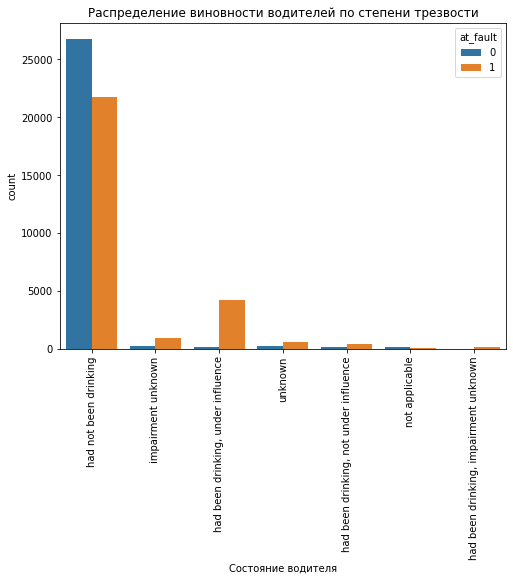

In [48]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.countplot(data=data, 
              x='party_sobriety', 
              hue = 'at_fault',
              ax=ax)
plt.title('Распределение виновности водителей по степени трезвости')
plt.xlabel('Состояние водителя')
plt.xticks(rotation=90)
plt.show()

## Выводы

Представленные таблицы работают корректно. Таблица case_ids не потребуется. Все таблицы связаны по ключу case_id. Условия: тип виновника — только машина (car) и данныe за 2012 год возможно соблюсти. Описание таблиц не совсем соответствует самим таблицам (например поле CONTROL_CONDITION_1 из описания не имеется в таблице collisions).
<br>По представленным данным видно, что в базу данных попало мало случаев аварий с июня по декабрь 2012 года. Либо данные были утеряны, либо в этот период не собирались вовсе. Для коллег-аналитиков был составлен ряд задач:
1. Узнать, у каких типов автомобилей выше процент аварий кроме царапин(таблицы collisions и vehicles);
2. Как страховка зависит от возраста автомобиля (таблицы parties и vehicles);
3. Проведите анализ серьёзности повреждений транспортного средства, исходя из состояния дороги в момент ДТП (таблицы collisions и parties);
4. Найдите самые частые причины ДТП (таблица parties);
5. Узнать, в какую погоду аварии происходят чаще (таблица collisions);
6. Найдите самые частые последствия аварии (таблица collisions);
7. Кто чаще всего выступает вторым участником происшествия (таблица collisions).

Например, решив первую задачу можно сделать вывод, что наиболее часто в серьезные аварии попадают автомобили типа сидан. Наименее часто купе. Решив вторую задачу, можно придти к выводу, что с повышением возраста автомобиля повышается и страховка, но это правило действует только для автомобилей от 2 до 15 лет С 16 до 20 лет страховка скорее понижается. Также имеется аномально высокий возраст авто - 161 год, что является мало вероятным событием.

Набор данных был подготовлен на основе первичного предположения заказчика:
1. Тип виновника — только машина (car);
2. ДТП привело к любым значимым повреждениям автомобиля любого из участников кроме типа SCRATCH (царапина);
3. Необходимы данные только за 2012 год.

Выгруженные по условиям Заказчика данные содержат 56247 случаев и состоят из множества признаков. Из признаков отберем для моделированиия самые полезные (те, что сильнее всего коррелируют с таргетом) Уберем постфактумные признаки (например, количество участников в аварии - они известны уже после аварии). В результате осталось только 7 признаков.
<br>Пропуски в категориальных столбцах были заполнены значением 'unknown'. Численные пропуски заполнены медианными значениями.

Видно, что водители на автомобилях с размером страховки до 30 тыс. и более 80 тыс. чаще виновны, чем водители со страховкой между этими значениями. В авариях с 21.00 до 6.00 чаще виноваты водители. Водители купе в 2012 году чаще оказывались виновниакми ДТП, чем сиданов. Информации по состоянию водителя (party_drug_physical, party_sobriety) по большей части отсутствует. Трезвые водители реже оказываются виновниками, но при этом трезвые водители участвовали в большинстве аварий. при дневном свете водители также часто оказываются невиновными (как выяснили ранее, водители вцелом днем реже виновники). Можно заметить, что в крупных округах водители реже виноваты. В малых же напротив водители чаще виноваты в ДТП.

Поскольку наблюдений много (более 50 тыс.) то нейросеть в работе не применялась (даже с меньшим количеством наблюдейний обучение затянется). Сравнивались 3 модели в пайплайне: KNeighborsClassifier, LGBMClassifier и CatBoostClassifier. За метрику качества была принята roc_auc, которая показывает, насколько хорошо классификатор различает положительные и отрицательные классы. Лучшей моделью оказалась CatBoostClassifier с метрикой roc_auc = 0.71 на тренировочных и тестовых данных, что является хорошим результатом. Выполненная матрица ошибок указывает на то, что Presision = 0.7, a Recall = 0.55. Следует отметить, что важность признаков в модели коррелирует с ранее обнаруженной корреляцией таргета с этими самыми признаками.

<br>**Рекомендации** С целью сокращения числа аварий следует ужесточить проверку состояния водителей перед поездкой (например создать автоматизированный алкотест перед допуском к управлению авто). Ужесточнение контроля за ПДД в мало населенных округах также положительно скажется на снижении опасности аварии. Необходимо дополнить данные за 2012 год для более корректного моделирования.